# Napari中的粉虱胚胎形态测量随时间变化
作者：Robert Haase, Daniela Vorkel, 2020

这是之前[为clij2发布的工作流程](https://clij.github.io/clij2-docs/md/tribolium_morphometry/)的pyclesperanto版本。
[ImageJ宏原版](https://github.com/clij/clij2-docs/tree/master/src/main/macro/tribolium_morphometry.ijm)

该脚本是大量GPU加速处理的一个示例。建议使用具有至少8 GB GDDR6内存的专用
显卡。否则，可能会相当慢。

让我们首先检查pyclesperanto是否已安装以及它使用的是哪个GPU。

In [1]:
import pyclesperanto_prototype as cle
import numpy as np

cle.select_device("RTX")

<Apple M1 Max on Platform: Apple (2 refs)>

## 加载数据集
该数据集显示了一个*粉虱*胚胎，由定制的光片显微镜在488nm波长下成像（成像致谢：Daniela Vorkel, Myers实验室, MPI CBG）。可以[从zenodo下载](https://zenodo.org/record/4276076#.YeLW8ljMJ_N)。
数据集已重新采样为1x1x1微米的体素大小。胚胎表达细胞核GFP。我们将使用该数据集来检测细胞核并生成估计的细胞分割。

所有处理步骤都在3D空间中执行。

In [2]:
from skimage.io import imread

timelapse = imread('/Users/haase/data/Lund_18.0_22.0_Hours-resampled.tif')

# 打印图像的空间维度
print(timelapse.shape)

(25, 140, 532, 266)


In [3]:
def process_image(image):
    import time

    start_time = time.time()
    
    # 将图像推送到GPU内存并显示
    gpu_input = cle.push(image)
    # print(gpu_input)
    
    # 高斯模糊
    sigma = 2.0
    gpu_blurred = cle.gaussian_blur(gpu_input, sigma_x=sigma, sigma_y=sigma, sigma_z=sigma)

    # 检测最大值
    gpu_detected_maxima = cle.detect_maxima_box(gpu_blurred)
    
    # 阈值
    threshold = 300.0
    gpu_thresholded = cle.greater_constant(gpu_blurred, constant=threshold)

    # 掩码
    gpu_masked_spots = cle.mask(gpu_detected_maxima, gpu_thresholded)

    # 标记斑点
    gpu_labelled_spots = cle.connected_components_labeling_box(gpu_masked_spots)
    # show_labels(gpu_labelled_spots)
    
    number_of_spots = int(cle.maximum_of_all_pixels(gpu_labelled_spots))
    # print("检测到的斑点数量: " + str(number_of_spots))
    
    # 标签图闭合
    number_of_dilations = 10
    flip = cle.create_labels_like(gpu_labelled_spots)
    flop = cle.create_labels_like(gpu_labelled_spots)
    flag = cle.create([1,1,1])
    cle.copy(gpu_labelled_spots, flip)

    for i in range (0, number_of_dilations) :
        cle.onlyzero_overwrite_maximum_box(flip, flag, flop)
        cle.onlyzero_overwrite_maximum_diamond(flop, flag, flip)

    # 腐蚀标签
    flap = cle.greater_constant(flip, constant=1)
    number_of_erosions = 4
    for i in range(0, number_of_erosions):
        cle.erode_box(flap, flop)
        cle.erode_box(flop, flap)

    gpu_labels = cle.mask(flip, flap)
    
    # 将结果从GPU作为numpy数组获取回来
    result = cle.pull(gpu_labels).astype(np.uint16)
        
    print("处理耗时 " + str(time.time() - start_time) + " 秒")

    return result

In [4]:
from skimage import data
import napari
viewer = napari.Viewer()

If you want to compute separable approximations, please install it with
pip install scikit-tensor-py3


In [5]:
# 体素大小 z,y,x
calibration = [1, 1, 1]

# 用于可视化的便捷函数
def show(image):
    viewer.add_image(image, scale=calibration)
    
def show_labels(labels):
    viewer.add_labels(labels, scale=calibration)

In [6]:
# 改编自：https://github.com/tlambert03/napari-dask-example/blob/master/dask_napari.ipynb
import dask
import dask.array as da

# 创建延迟图像读取器的dask堆栈
lazy_process_image = dask.delayed(process_image)  # 延迟读取器
lazy_arrays = [lazy_process_image(timelapse[n]) for n in range(0, timelapse.shape[0])]
dask_arrays = [
    da.from_delayed(lazy_array, shape=timelapse[0].shape, dtype=np.uint16)
    for lazy_array in lazy_arrays
]
# 堆叠成一个大的dask.array
dask_stack = da.stack(dask_arrays, axis=0)
dask_stack

dask.array<stack, shape=(25, 140, 532, 266), dtype=uint16, chunksize=(1, 140, 532, 266), chunktype=numpy.ndarray>

In [7]:
print(timelapse.shape[0])

25


In [8]:
show(timelapse)
show_labels(dask_stack)

Processing took 0.3502938747406006 s
Processing took 0.268435001373291 s
Processing took 0.2793867588043213 s


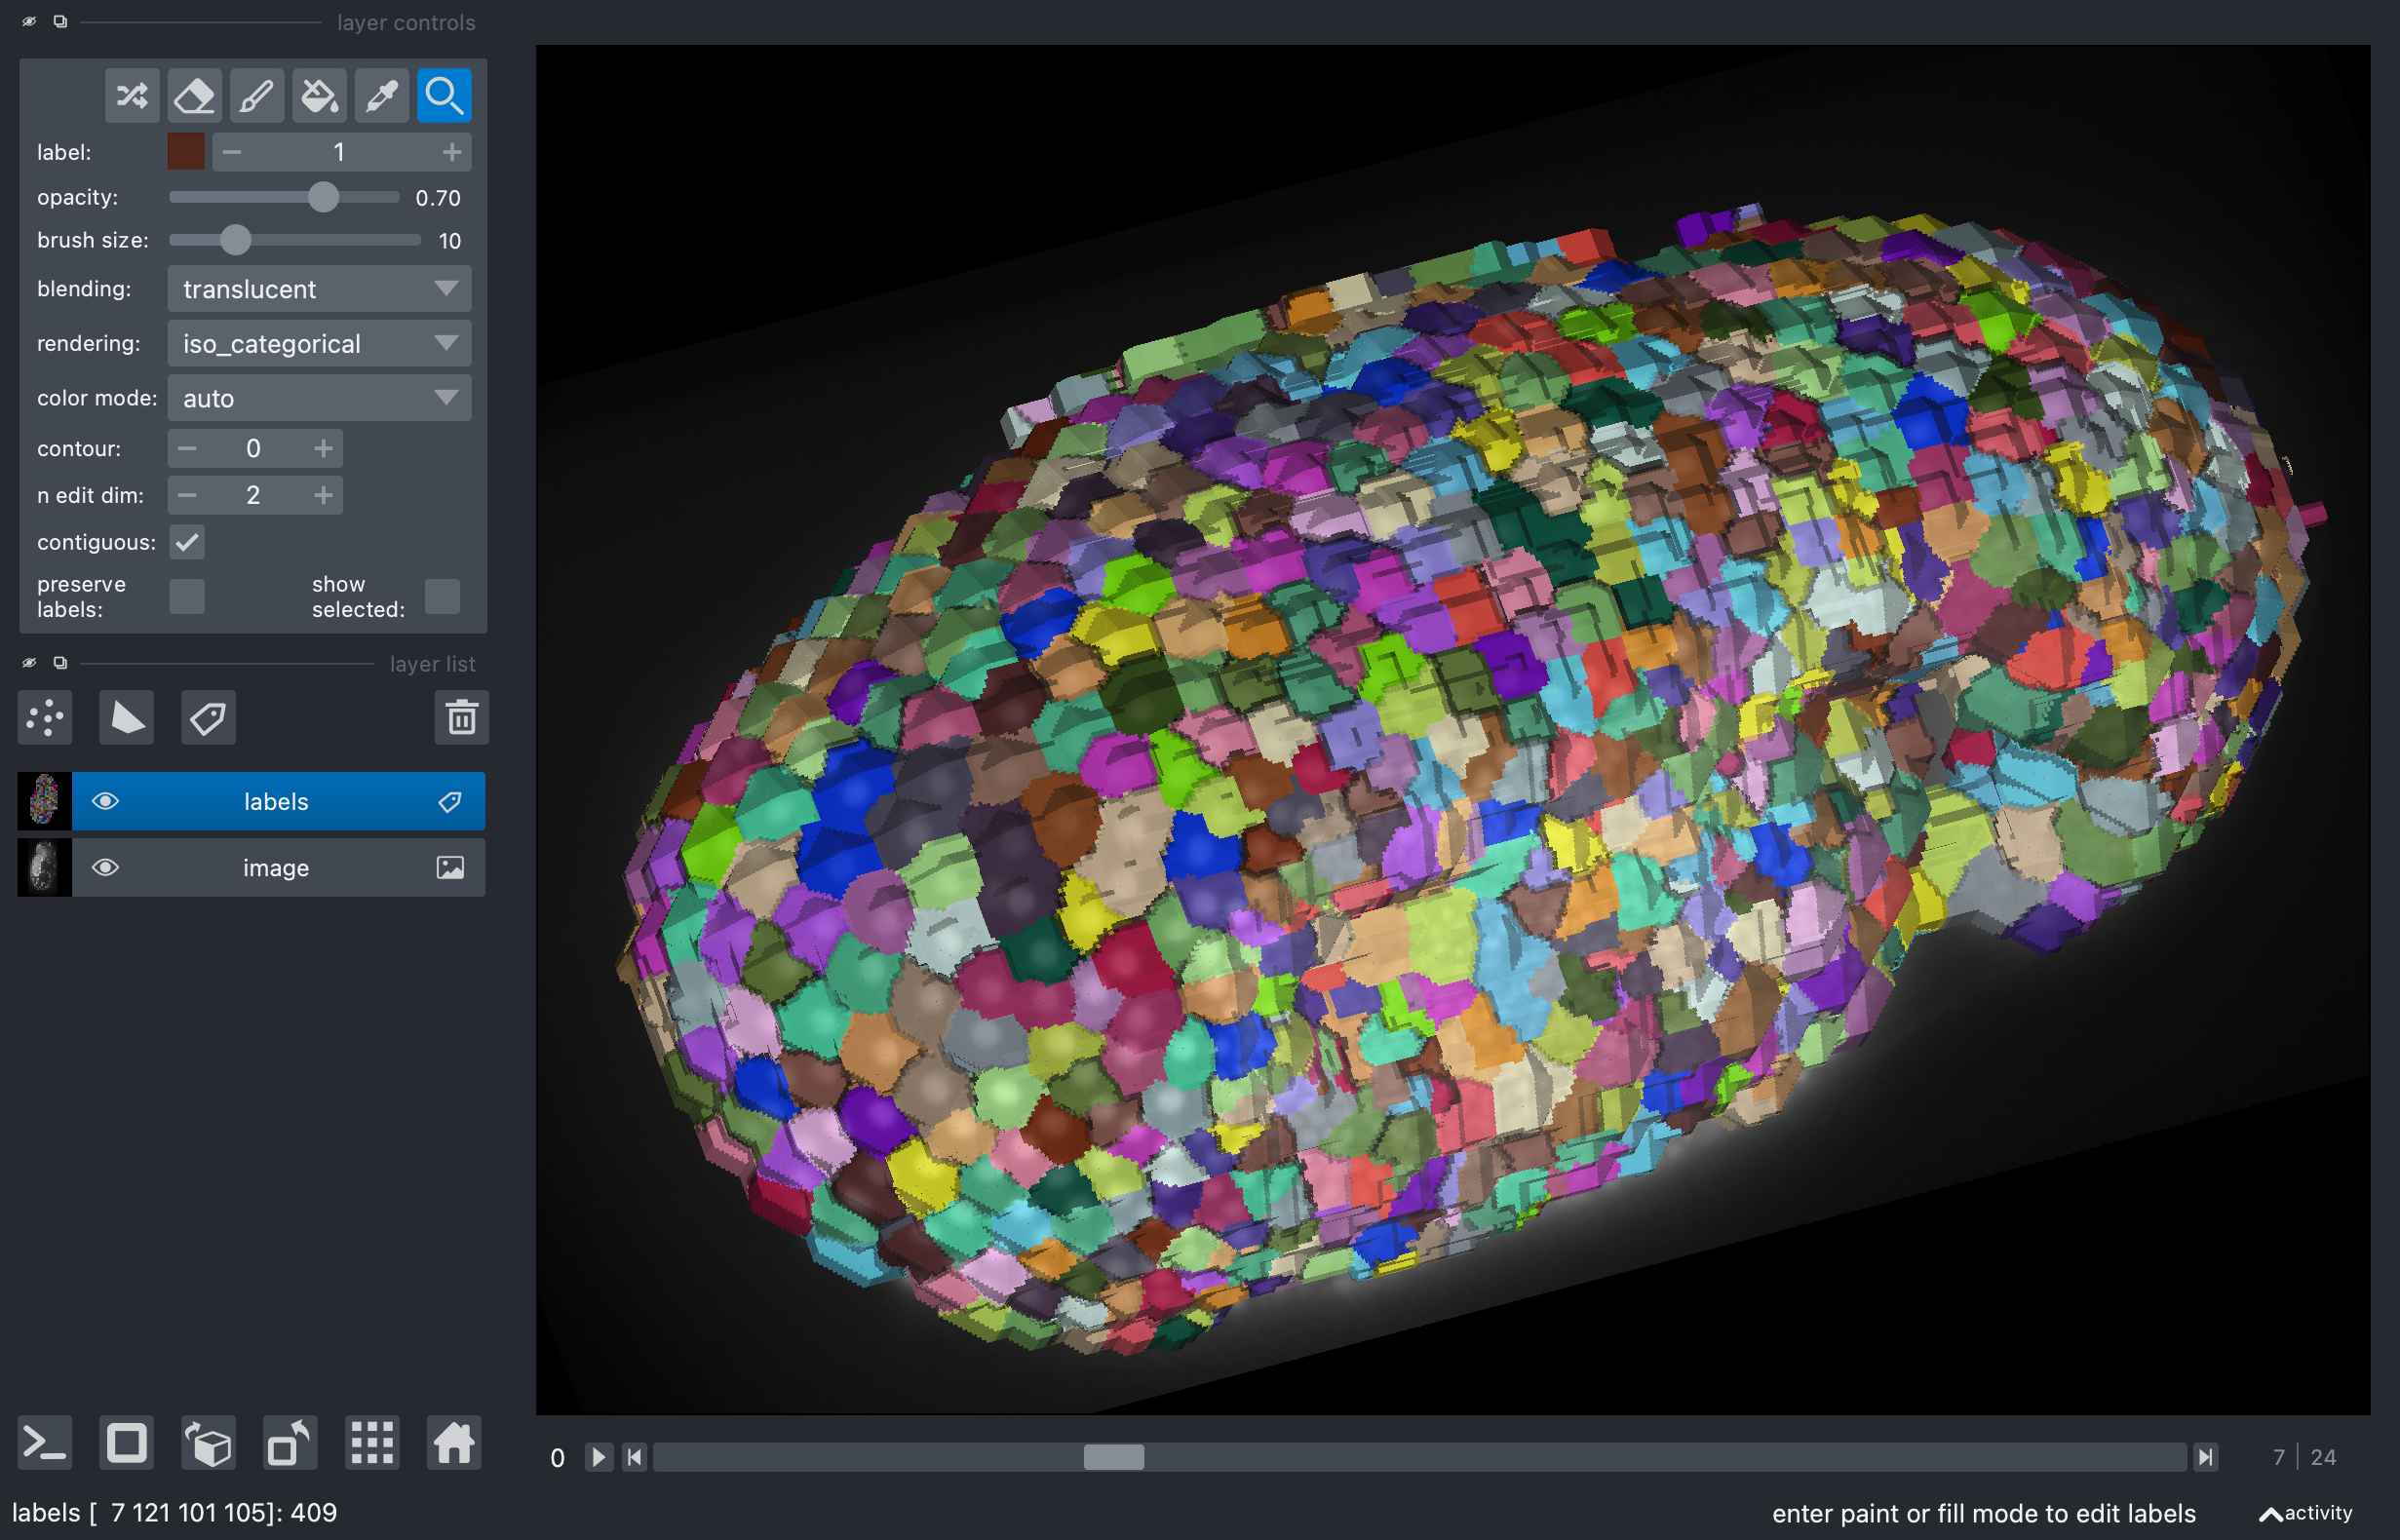

In [9]:
from napari.utils import nbscreenshot
nbscreenshot(viewer)